In [ ]:
!pip install catboost pandas scikit-learn matplotlib


In [1]:
import numpy as np
print(np.__version__)
print(np.char.lower(['TEST']))


1.26.4
['test']


In [ ]:
!pip install imbalanced-learn


In [6]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from itertools import product

df = pd.read_csv("Preprocessed_data.csv")
df.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")

y = df["RECURRENCE"]
X = df.drop(columns=["RECURRENCE"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df["RECURRENCE"] = y_resampled.values
resampled_df.to_csv("SMOTE_Resampled_Data.csv", index=False)

model = CatBoostClassifier(eval_metric="AUC", verbose=0, random_state=42)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

def generate_treatment_combos():
    return [
        {"SURGERY": s, "RADIOTHERAPY": r, "CHEMOTHERAPY": c}
        for s, r, c in product([0, 1], repeat=3)
        if not (s == r == c == 0)
    ]

patient = X_test.iloc[0].copy()
non_treatments = ["SURGERY", "RADIOTHERAPY", "CHEMOTHERAPY"]
patient_info = {col: patient[col] for col in X.columns if col not in non_treatments}

results = []
for combo in generate_treatment_combos():
    test_case = patient_info.copy()
    test_case.update(combo)
    df_input = pd.DataFrame([test_case])
    prob = model.predict_proba(df_input)[0][1]
    results.append({
        **combo,
        "Recurrence Probability": round(prob, 3),
        "Estimated 5-Year Survival": round(1 - prob, 3)
    })

results_df = pd.DataFrame(results)
print("\nSimulated Treatment Outcomes:\n")
print(results_df)


Confusion Matrix:
 [[46  7]
 [ 5  2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88        53
           1       0.22      0.29      0.25         7

    accuracy                           0.80        60
   macro avg       0.56      0.58      0.57        60
weighted avg       0.82      0.80      0.81        60


ROC AUC Score: 0.6064690026954178

Simulated Treatment Outcomes:

   SURGERY  RADIOTHERAPY  CHEMOTHERAPY  Recurrence Probability  \
0        0             0             1                   0.164   
1        0             1             0                   0.320   
2        0             1             1                   0.154   
3        1             0             0                   0.070   
4        1             0             1                   0.042   
5        1             1             0                   0.076   
6        1             1             1                   0.036   

   Estimated 5

0:	total: 2.35ms	remaining: 4.69s
100:	total: 140ms	remaining: 2.63s
200:	total: 281ms	remaining: 2.51s
300:	total: 480ms	remaining: 2.71s
400:	total: 640ms	remaining: 2.55s
500:	total: 813ms	remaining: 2.43s
600:	total: 976ms	remaining: 2.27s
700:	total: 1.13s	remaining: 2.1s
800:	total: 1.29s	remaining: 1.93s
900:	total: 1.45s	remaining: 1.77s
1000:	total: 1.61s	remaining: 1.6s
1100:	total: 1.78s	remaining: 1.45s
1200:	total: 1.96s	remaining: 1.3s
1300:	total: 2.13s	remaining: 1.14s
1400:	total: 2.3s	remaining: 982ms
1500:	total: 2.46s	remaining: 820ms
1600:	total: 2.64s	remaining: 658ms
1700:	total: 2.96s	remaining: 521ms
1800:	total: 3.25s	remaining: 359ms
1900:	total: 3.56s	remaining: 185ms
1999:	total: 3.83s	remaining: 0us


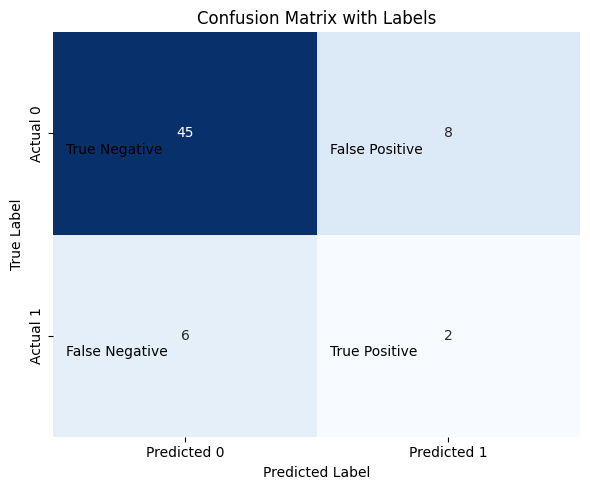


Simulated Treatment Outcomes:
   SURGERY  RADIOTHERAPY  CHEMOTHERAPY  Recurrence Probability  \
0        0             0             1                   0.058   
1        0             1             0                   0.897   
2        0             1             1                   0.065   
3        1             0             0                   0.121   
4        1             0             1                   0.004   
5        1             1             0                   0.240   
6        1             1             1                   0.003   

   Estimated 5-Year Survival  
0                      0.942  
1                      0.103  
2                      0.935  
3                      0.879  
4                      0.996  
5                      0.760  
6                      0.997  

SMOTE-resampled training data saved as 'SMOTE_Stratifed_Train.csv'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Preprocessed_data.csv")
df.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")

df_class_0 = df[df["RECURRENCE"] == 0]
df_class_1 = df[df["RECURRENCE"] == 1]

train_0, test_0 = train_test_split(df_class_0, test_size=0.2, random_state=42)
train_1, test_1 = train_test_split(df_class_1, test_size=0.2, random_state=42)

train_df = pd.concat([train_0, train_1]).sample(frac=1, random_state=42)
test_df = pd.concat([test_0, test_1]).sample(frac=1, random_state=42)

X_train = train_df.drop(columns=["RECURRENCE"])
y_train = train_df["RECURRENCE"]
X_test = test_df.drop(columns=["RECURRENCE"])
y_test = test_df["RECURRENCE"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#  Deep CatBoost Model
model = CatBoostClassifier(
    depth=8,
    learning_rate=0.02,
    iterations=2000,
    l2_leaf_reg=5,
    class_weights=[1, 5],  # Heavier penalty on missing recurrence
    eval_metric="AUC",
    random_state=42,
    verbose=100
)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
cm_values = cm.reshape(-1)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0','Predicted 1'],
            yticklabels=['Actual 0','Actual 1'])
for i, label in enumerate(labels):
    row, col = divmod(i, 2)
    plt.text(col + 0.05, row + 0.6, label, color='black', fontsize=10)

plt.title('Confusion Matrix with Labels')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


def generate_treatment_combos():
    return [
        {"SURGERY": s, "RADIOTHERAPY": r, "CHEMOTHERAPY": c}
        for s, r, c in product([0, 1], repeat=3)
        if not (s == r == c == 0)
    ]

patient = X_test.iloc[0].copy()
non_treatment_cols = ["SURGERY", "RADIOTHERAPY", "CHEMOTHERAPY"]
patient_info = {col: patient[col] for col in X_train.columns if col not in non_treatment_cols}

results = []
for combo in generate_treatment_combos():
    input_data = patient_info.copy()
    input_data.update(combo)
    df_input = pd.DataFrame([input_data])
    prob = model.predict_proba(df_input)[0][1]
    results.append({
        **combo,
        "Recurrence Probability": round(prob, 3),
        "Estimated 5-Year Survival": round(1 - prob, 3)
    })

results_df = pd.DataFrame(results)
print("\nSimulated Treatment Outcomes:")
print(results_df)

resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
resampled_df["RECURRENCE"] = y_resampled.values
resampled_df.to_csv("SMOTE_Stratifed_Train.csv", index=False)
print("\nSMOTE-resampled training data saved as 'SMOTE_Stratifed_Train.csv'")


In [9]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[45  8]
 [ 6  2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87        53
           1       0.20      0.25      0.22         8

    accuracy                           0.77        61
   macro avg       0.54      0.55      0.54        61
weighted avg       0.79      0.77      0.78        61


ROC AUC Score: 0.6509433962264151
